In [ ]:
from  fastai.vision.all import *

In [ ]:
path = fastai.vision.all.untar_data(URLs.PASCAL_2007)

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
dblock = DataBlock()
dsets = dblock.datasets(df)
dsets.train[0]

(fname       009738.jpg
 labels          person
 is_valid          True
 Name: 4899, dtype: object, fname       009738.jpg
 labels          person
 is_valid          True
 Name: 4899, dtype: object)

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid
    
# dblock = DataBlock( get_x = lambda r : path/'train'/r['fname'], get_y = lambda r : r['labels'].split(' '))

dblock = DataBlock((ImageBlock, MultiCategoryBlock), get_x = lambda r : path/'train'/r['fname'], get_y = lambda r : r['labels'].split(' '),
                   splitter = lambda x : (x.index[~df['is_valid']].tolist(), x.index[df['is_valid']].tolist()),
                   item_tfms = RandomResizedCrop(128, min_scale = 0.35))

dsets = dblock.datasets(df)
dls = dblock.dataloaders(df)
dsets.train[0]

TypeError: ignored

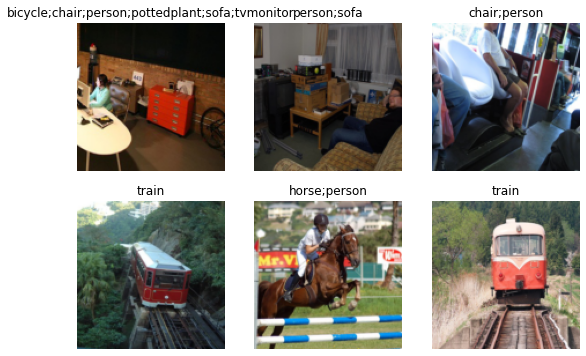

In [ ]:
dls.show_batch(nrows=2, ncols = 3)

In [ ]:
dblock.summary(df)
# dblock.summary(path/'train.csv') 안됨
# (path/'train').ls()

In [ ]:
learn = cnn_learner(dls, resnet18)
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f370

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([64, 20])

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0674, grad_fn=<AliasBackward0>)

In [97]:
def accuracy_multi(inp, targ, thresh = 0.9):
    inp = sigmoid(inp)
    return ((inp>thresh) == targ.bool()).float().mean()

In [ ]:
learn.metrics = partial(accuracy_multi)
learn.validate()

(#2) [1.4858620166778564,0.6032270193099976]

In [92]:
preds, targg = learn.get_preds()

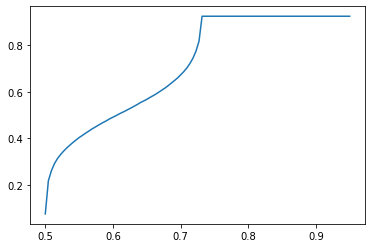

In [99]:
# finding threshold value 
xs = torch.linspace(0.5,0.95,100)
accs = [accuracy_multi(preds, targg, thresh = i) for i in xs]
plt.plot(xs, accs)